### Финальный проект
Датасет содержит данные о погоде, собранные в городе Дели за период 4 лет (с 2013 по 2017 год).

In [127]:
import pandas as pd
import matplotlib.pyplot  as plt
import numpy as np
import seaborn as sns
import os
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from sklearn.ensemble import RandomForestRegressor
from numpy import asarray
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from tqdm import tqdm
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score
from math import sqrt
import warnings
import random
from pmdarima import auto_arima
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as torch_data
from itertools import combinations
from statsmodels.tsa.stattools import coint, grangercausalitytests
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.statespace.varmax import VARMAX
from sklearn import metrics
# from tensorflow.keras import Input, Model
# from tensorflow.keras.layers import Dense
# from tcn import TCN


random.seed(1)
np.random.seed(1)
torch.manual_seed(1)
torch.cuda.manual_seed(1)
torch.backends.cudnn.deterministic = True

### Предобрабока временного ряда

In [128]:
data_train = pd.read_csv('data/DailyDelhiClimateTrain.csv')
data_test = pd.read_csv('data/DailyDelhiClimateTest.csv')

data = pd.concat([data_train, data_test], axis=0)
del data['meanpressure']
data.head()

,date,meantemp,humidity,wind_speed
0,2013-01-01,10.000000,84.500000,0.000000
1,2013-01-02,7.400000,92.000000,2.980000
2,2013-01-03,7.166667,87.000000,4.633333
3,2013-01-04,8.666667,71.333333,1.233333
4,2013-01-05,6.000000,86.833333,3.700000


In [129]:
data['date']=pd.to_datetime(data['date'])
data.set_index(data['date'], inplace=True)
data = data.drop('date', axis=1)

data.head()

,meantemp,humidity,wind_speed
date,,,
2013-01-01,10.000000,84.500000,0.000000
2013-01-02,7.400000,92.000000,2.980000
2013-01-03,7.166667,87.000000,4.633333
2013-01-04,8.666667,71.333333,1.233333
2013-01-05,6.000000,86.833333,3.700000


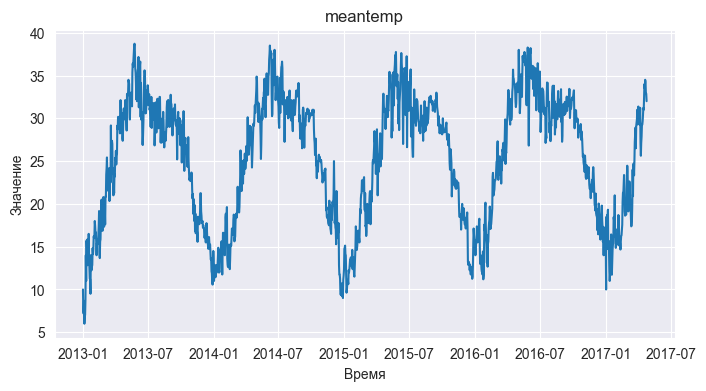

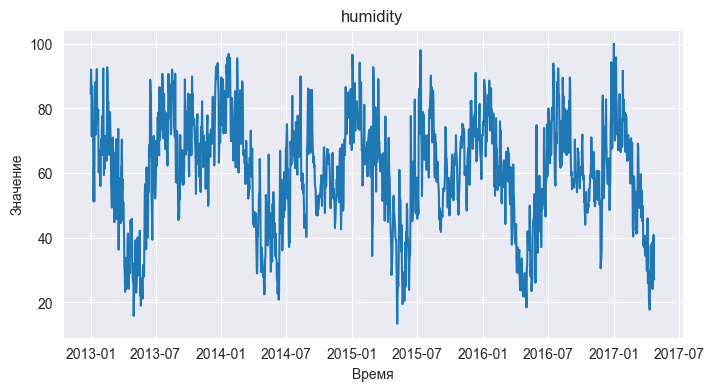

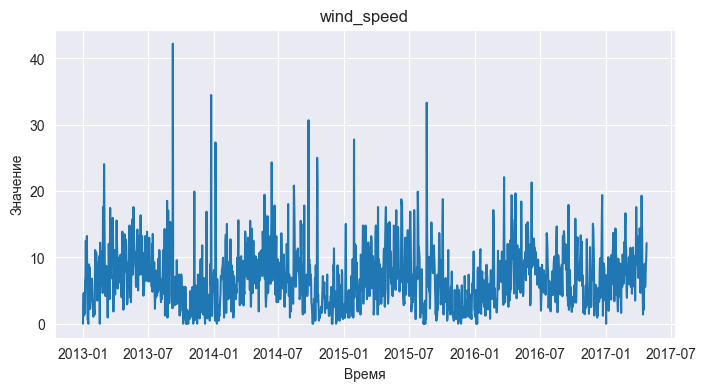

In [130]:
columns = data.columns

for column in columns:
    if column != 'Date':
        plt.figure(figsize=(8, 4))
        plt.plot(data[column])
        plt.title(column)
        plt.xlabel('Время')
        plt.ylabel('Значение')
        plt.show()

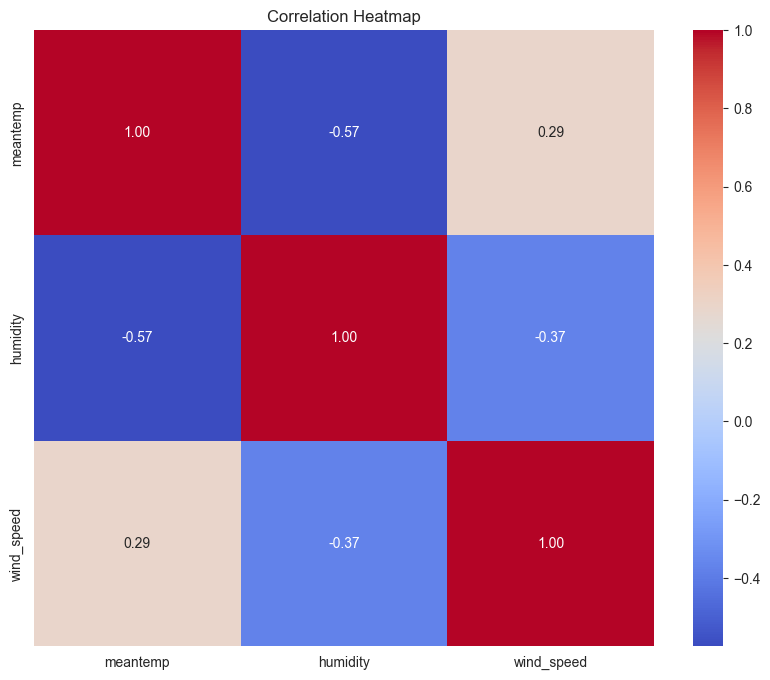

In [174]:

correlation_matrix = data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

Проверка на пропуски

In [131]:
missing_values = data.isnull().sum()
missing_values

meantemp      0
humidity      0
wind_speed    0
dtype: int64

Составляющие ряда

In [132]:
def seasonal(column):
    rcParams['figure.figsize'] = 20, 9
    decompose = seasonal_decompose(data[column], period=500)
    decompose.plot()
    plt.show()


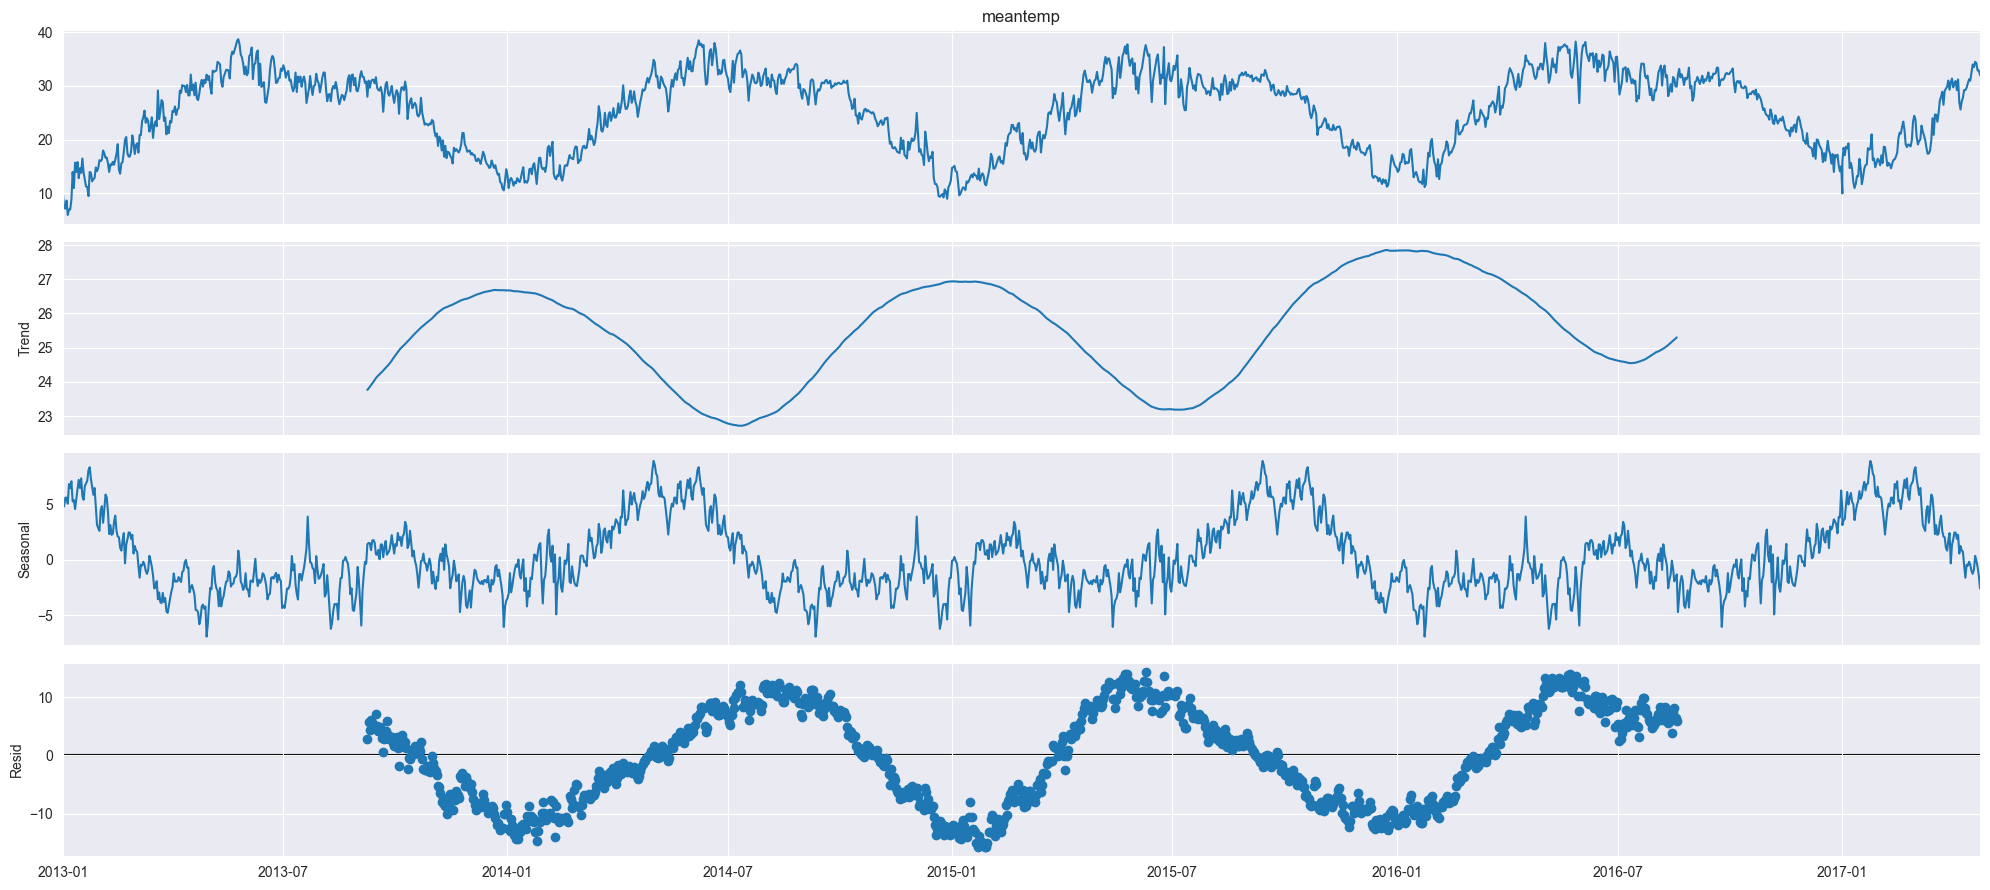

In [133]:
seasonal('meantemp')

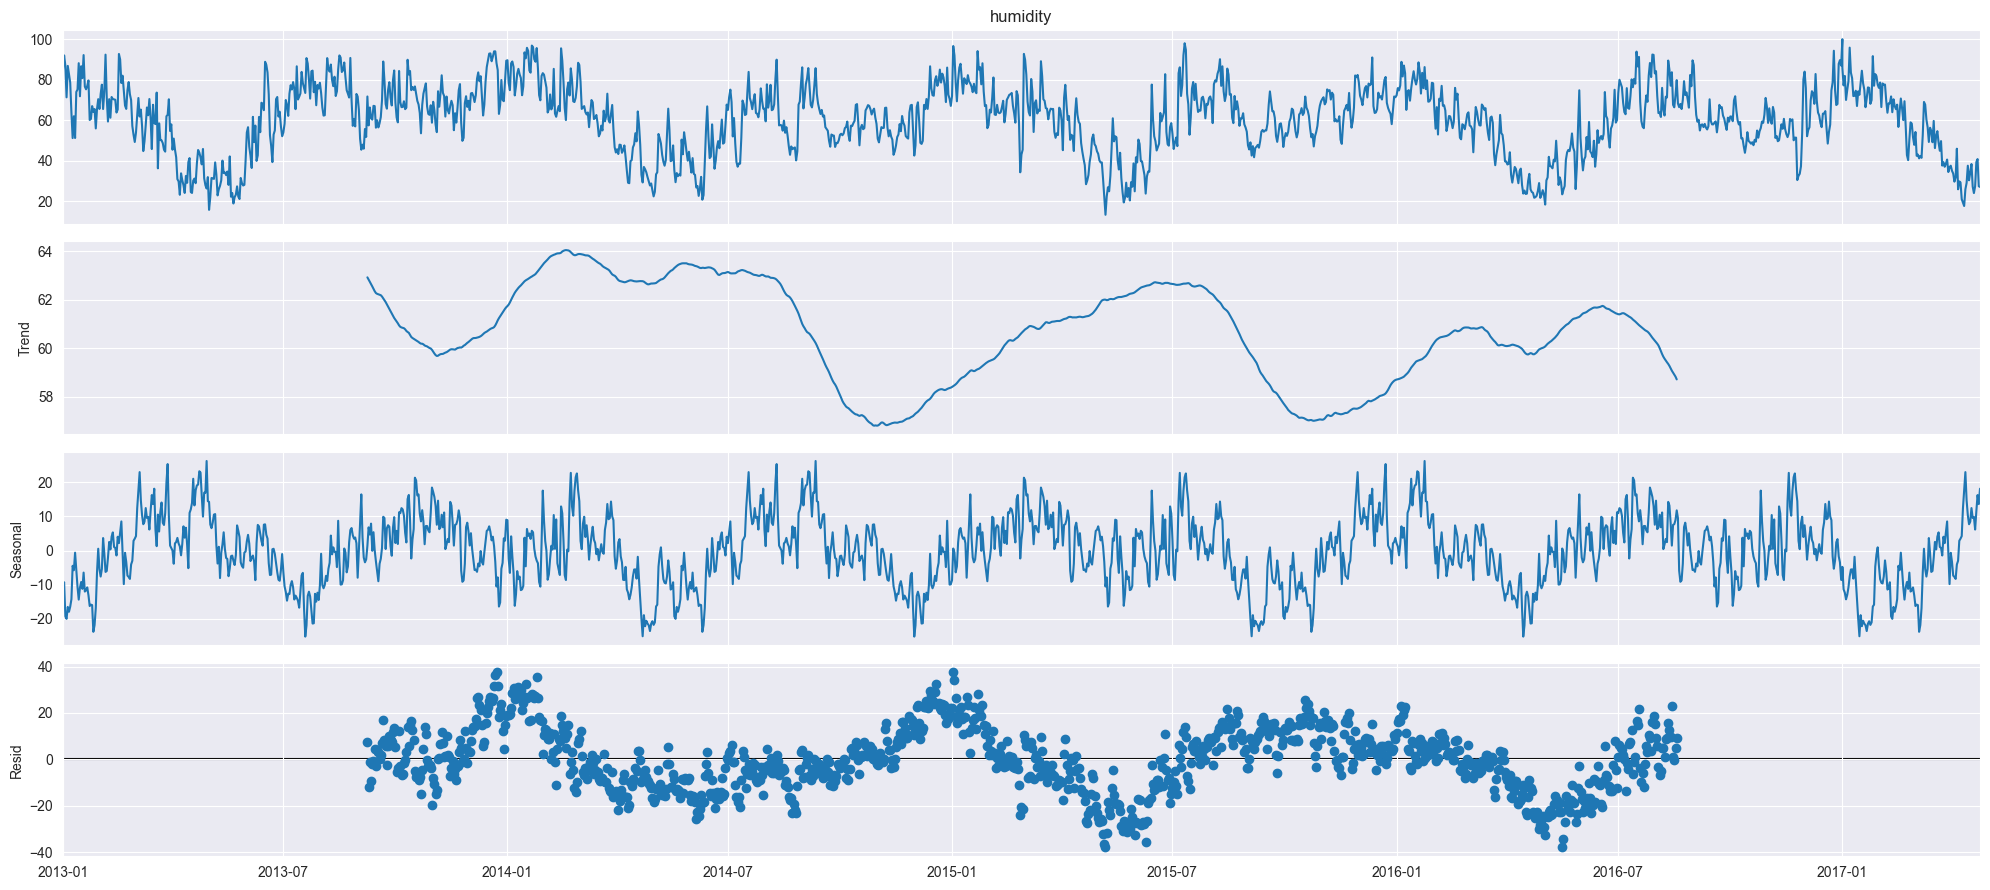

In [134]:
seasonal('humidity')

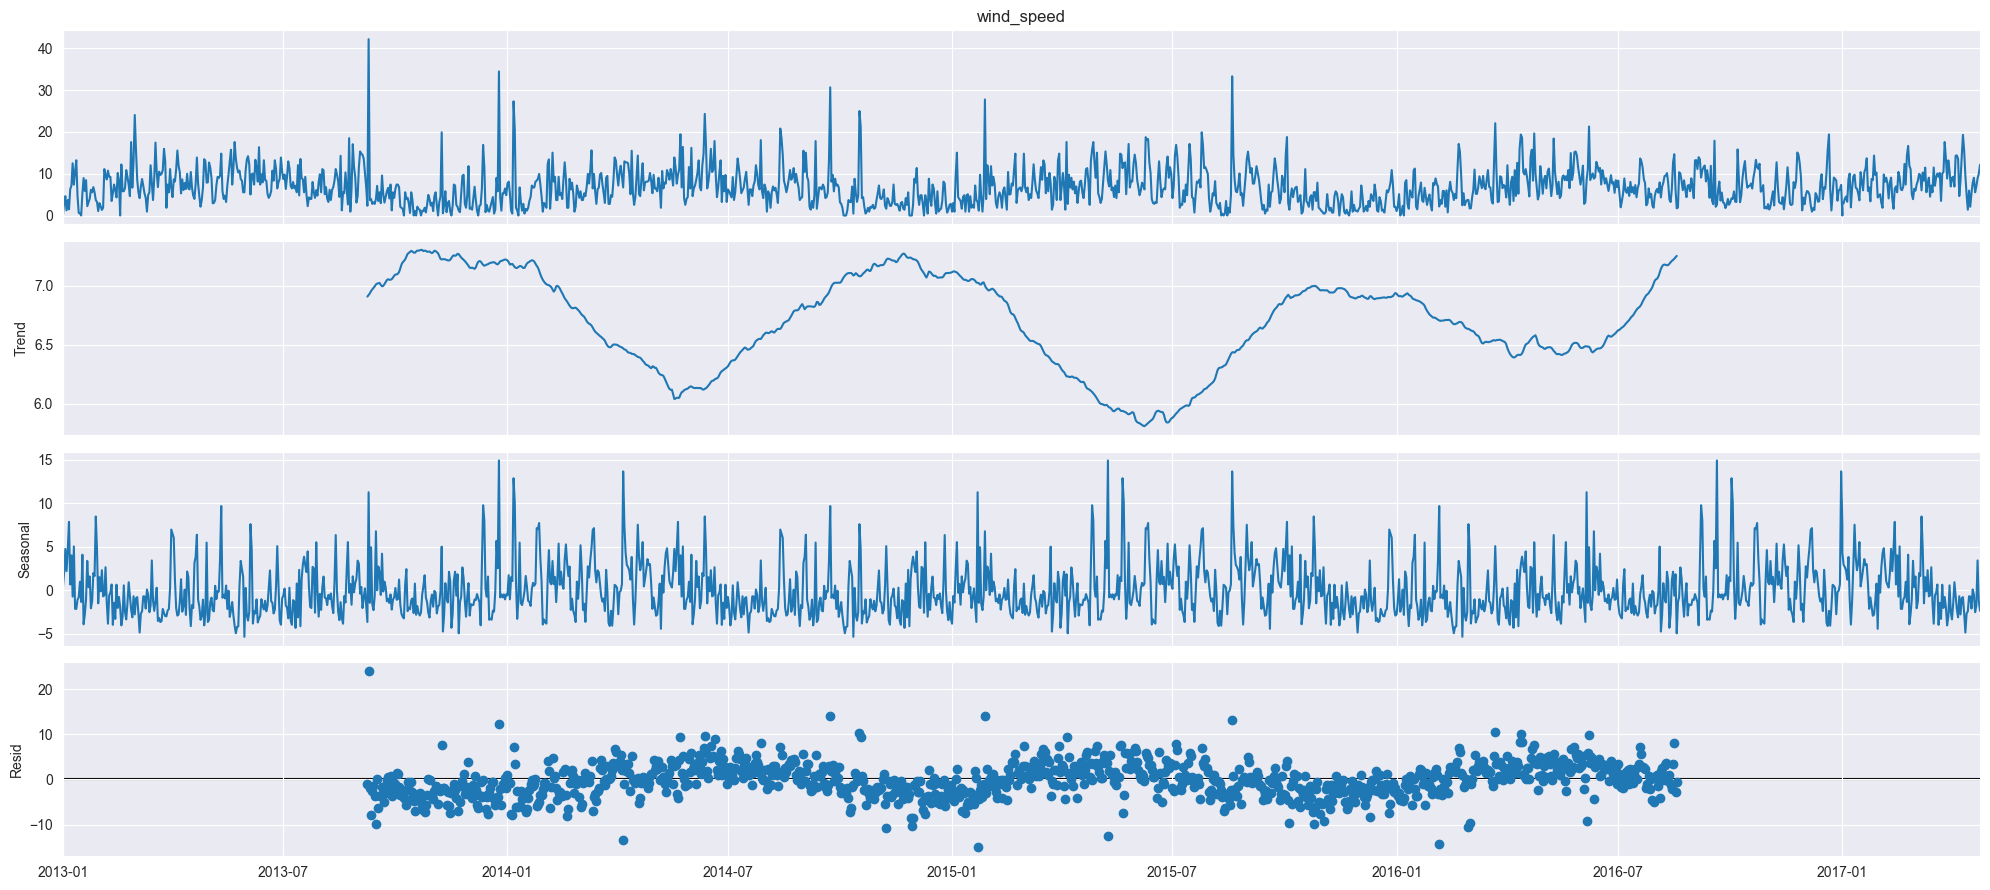

In [135]:
seasonal('wind_speed')

Проверка на стационарность

In [136]:
def df_test(name: str, df: pd.Series) -> None:
    alpha = 0.05
    name = name
    ts = df
    print(f"Тест Дики-Фуллера ряда {name}:")
    dftest = adfuller(ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Users', 'Number of Observations Used'])

    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    if dfoutput["p-value"] < alpha:
        print(f"Значение p меньше {alpha*100}%. Ряд стационарный.")
    else:
        print(f"Значение p больше {alpha*100}%. Ряд не стационарный.")

In [137]:
df_test("meantemp", data["meantemp"])

Тест Дики-Фуллера ряда meantemp:
Test Statistic                   -2.379190
p-value                           0.147696
#Lags Users                      10.000000
Number of Observations Used    1565.000000
Critical Value (1%)              -3.434535
Critical Value (5%)              -2.863389
Critical Value (10%)             -2.567754
dtype: float64
Значение p больше 5.0%. Ряд не стационарный.


In [138]:
df_test("humidity", data["humidity"])

Тест Дики-Фуллера ряда humidity:
Test Statistic                   -3.628942
p-value                           0.005231
#Lags Users                      15.000000
Number of Observations Used    1560.000000
Critical Value (1%)              -3.434549
Critical Value (5%)              -2.863395
Critical Value (10%)             -2.567757
dtype: float64
Значение p меньше 5.0%. Ряд стационарный.


In [139]:
df_test("wind_speed", data["wind_speed"])

Тест Дики-Фуллера ряда wind_speed:
Test Statistic                   -4.013221
p-value                           0.001343
#Lags Users                      24.000000
Number of Observations Used    1551.000000
Critical Value (1%)              -3.434573
Critical Value (5%)              -2.863405
Critical Value (10%)             -2.567763
dtype: float64
Значение p меньше 5.0%. Ряд стационарный.


Сезонное дифференцирование

In [140]:
# del data['date']
lags = 15
df_data = data.diff(periods=lags).dropna()
# data_test = data_test.diff(periods=lags).dropna()
df_test("meantemp", df_data["meantemp"])

Тест Дики-Фуллера ряда meantemp:
Test Statistic                   -4.925378
p-value                           0.000031
#Lags Users                      19.000000
Number of Observations Used    1541.000000
Critical Value (1%)              -3.434601
Critical Value (5%)              -2.863417
Critical Value (10%)             -2.567769
dtype: float64
Значение p меньше 5.0%. Ряд стационарный.


### Коинтеграция
Коинтеграция временных рядов представляет собой явление, при котором два или более временных ряда демонстрируют причинно-следственную зависимость на уровне их уровней, выраженную в совпадении или противоположной направленности общих тенденций и стохастических колебаний.

Обнаружение коинтеграции подразумевает, что эти временные ряды могут быть использованы для построения моделей, учитывающих их долгосрочные взаимосвязи с целью достижения более точных прогнозов. Для этого часто применяются модели, такие как VAR (векторная авторегрессия), VARMA (векторная авторегрессия с подвижным средним) и другие.

In [141]:
pairs = combinations(df_data.columns, 2)

for pair in pairs:
    pair_data = df_data[list(pair)]
    score, pvalue, _ = coint(pair_data[pair[0]], pair_data[pair[1]])

    if pvalue < 0.05:
        print(f"Есть коинтеграция между {pair[0]} и {pair[1]}")
    else:
        print(f"Отсутствует коинтеграция между {pair[0]} и {pair[1]}")

Есть коинтеграция между meantemp и humidity
Есть коинтеграция между meantemp и wind_speed
Есть коинтеграция между humidity и wind_speed


### Грейнджер


In [142]:
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in tqdm(df.columns):
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df
warnings.filterwarnings("ignore")
j_test = grangers_causation_matrix(df_data, variables = data.columns)
warnings.filterwarnings("default")
j_test

100%|██████████| 3/3 [00:00<00:00,  5.58it/s]


,meantemp_x,humidity_x,wind_speed_x
meantemp_y,1.0,0.0104,0.0000
humidity_y,0.0,1.0000,0.0615
wind_speed_y,0.0,0.0000,1.0000


In [143]:
train, test = df_data[:1200], df_data[1200:]

max_p = 100
model = VAR(df_data)

best_p = model.select_order(maxlags=max_p).selected_orders['aic']

print("Optimal p:", best_p)

/Users/david/TimeSeries/FinalProject/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Optimal p: 93


In [144]:
model_fitted = model.fit(93)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 09, Jan, 2024
Time:                     21:55:40
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    10.8176
Nobs:                     1468.00    HQIC:                   8.91895
Log likelihood:          -11126.7    FPE:                    2450.17
AIC:                      7.78972    Det(Omega_mle):         1451.28
--------------------------------------------------------------------
Results for equation meantemp
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const                  0.006112         0.042811            0.143           0.886
L1.meantemp            0.800651         0.038305           20.902           0.000
L1.humidity            0.014016         0.008130     

In [145]:
def create_test_dataset(test, in_seq_order, for_len=1, step=1):
    X_test = []
    Y_test = []
    for i in range(0, len(test) - for_len - in_seq_order, step):
        X_test.append(test[i:(i+in_seq_order)].to_numpy())
        Y_test.append(test[(i+in_seq_order):(i+in_seq_order+for_len)].to_numpy())
    return X_test, Y_test

def create_train_dataset(train, in_seq_order, for_len=1, step=1):
    X_train = []
    Y_train = []
    for i in range(0, len(train) - for_len - in_seq_order, step):
        X_train.append(train[i:(i+in_seq_order)].to_numpy())
        Y_train.append(train[(i+in_seq_order):(i+in_seq_order+for_len)].to_numpy())
    return X_train, Y_train

In [146]:
X_test, Y_test = create_test_dataset(test, 93)
X_train, Y_train = create_train_dataset(train, 93)

In [147]:
Y_pred = []

for i in X_test:
    Y_pred.append(model_fitted.forecast(y=i,steps=1))

In [148]:
Y_pred = np.array(Y_pred)
Y_test = np.array(Y_test)

Y_train = np.array(Y_train)

In [149]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt


def smape_score(actual, predicted) -> float:
    if not all([isinstance(actual, np.ndarray),
                isinstance(predicted, np.ndarray)]):
        actual, predicted = np.array(actual), np.array(predicted)

    return round(np.mean(np.abs(predicted - actual) /
                         ((np.abs(predicted) + np.abs(actual)) / 2)), 3)

def validate(name, true, pred):
    print(f"Метрики {name}")
    print("MSE:", mean_squared_error(true, pred))
    print("RMSE:", sqrt(mean_squared_error(true, pred)))
    print("MAE:", mean_absolute_error(true, pred))
    print("SMAPE:", smape_score(true, pred))
    print("R2:", r2_score(true, pred),"\n")

def plot_and_metrics(columns_name, true, pred, train):
    for n in range(len(columns_name)):
        name = columns_name[n]
        Y_true = true[:, :, n]
        Y_pred = pred[:, :, n]
        Y_train = train[:, :, n]

        plt.figure(figsize=(8, 6))
        plt.plot(Y_train, label='Train')
        plt.plot(range(len(Y_train), len(Y_test) + len(Y_train)), Y_true, label='True')
        plt.plot(range(len(Y_train), len(Y_test) + len(Y_train)), Y_pred, label='Predicted')
        plt.title(f"{name} - True vs Predicted")
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.legend()
        plt.show()

        validate(name, Y_true, Y_pred)

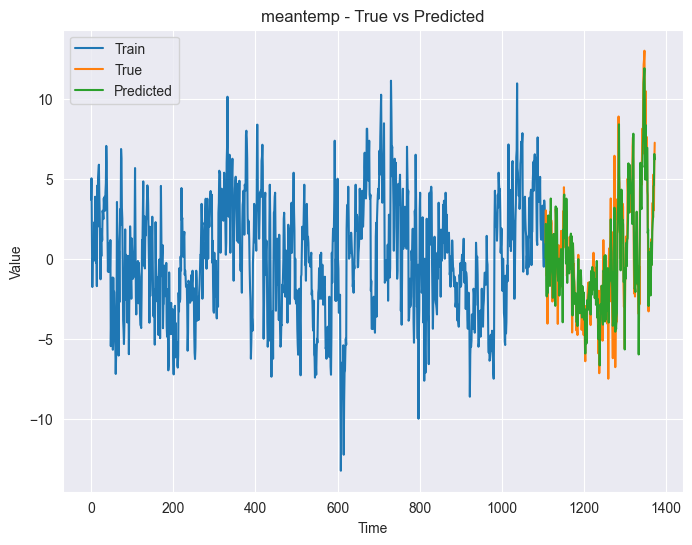

Метрики meantemp
MSE: 2.0713272317351867
RMSE: 1.4392106279954948
MAE: 1.135090941393128
SMAPE: 0.642
R2: 0.8405721471966162 



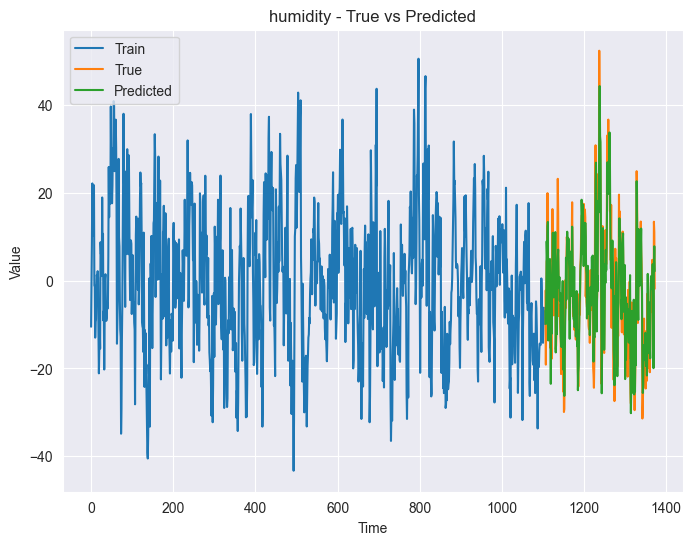

Метрики humidity
MSE: 48.31918264766751
RMSE: 6.951200086867556
MAE: 5.558709754983596
SMAPE: 0.756
R2: 0.7638758119897969 



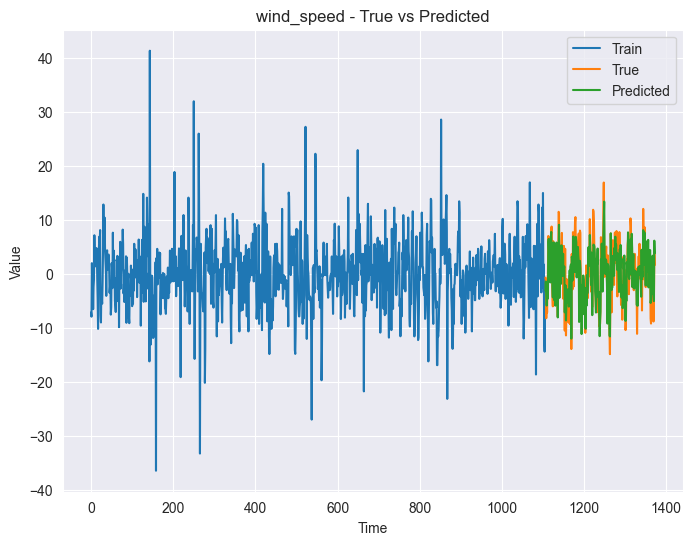

Метрики wind_speed
MSE: 10.529963968754673
RMSE: 3.244990596096493
MAE: 2.6088994385473767
SMAPE: 0.863
R2: 0.6437479054031485 



In [150]:
plot_and_metrics(data.columns, Y_test, Y_pred, Y_train)

Метрики показывают достаточно средний результат предсказания
MSE RMSE MAE должны стремиться к 0
SMAPE R2 показывает что в среднем только около 80% данных объясняется моделью

### VARMA

In [151]:
train, test = data[:1200], data[1200:]
df_train = train.diff()

Подбор параметров для обучения

In [152]:
pq = []
for name, column in df_data.items():
    print(f'Поиск оптимальных значений p и q для: {name}')
    stepwise_model = auto_arima(data[name], start_p=1, start_q=1, max_p=7, max_q=7, seasonal=False,
        trace=True, error_action='ignore', suppress_warnings=True, stepwise=True, maxiter=1000)
    params = stepwise_model.get_params().get('order')
    print(f'Оптимальные значения для {name}: {params} \n\n')
    pq.append(params)

Поиск оптимальных значений p и q для: meantemp
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=6063.156, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=14776.458, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=12761.169, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=6004.752, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=6006.517, Time=0.28 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=6066.979, Time=0.21 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=6036.805, Time=0.05 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=6005.617, Time=0.70 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=6001.754, Time=0.39 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=6052.479, Time=0.15 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=6061.620, Time=0.13 sec

In [153]:
pq.remove((2, 0, 1))

In [154]:
def inverse_diff(actual_df, pred_df):
    df_res = pred_df.copy()
    columns = actual_df.columns
    for col in columns:
        last_actual_value = actual_df[col].iloc[-1]
        df_res[str(col) + '_1st_inv_diff'] = last_actual_value + df_res[str(col)].cumsum()
    return df_res

In [155]:
df_results_moni = pd.DataFrame(columns=['p', 'q','RMSE meantemp','RMSE humidity','RMSE wind_speed'])
for i in pq:
    if i[0]== 0 and i[2]==0:
        pass
    else:
        model = VARMAX(df_train, order=(i[0],i[2])).fit(disp=False)
        result = model.forecast(steps = len(test))
        inv_res = inverse_diff(data, result)
        meantemprmse = np.sqrt(metrics.mean_squared_error(test['meantemp'], inv_res.meantemp_1st_inv_diff))
        humidityrmse = np.sqrt(metrics.mean_squared_error(test['humidity'], inv_res.humidity_1st_inv_diff))
        wind_speedrmse = np.sqrt(metrics.mean_squared_error(test['wind_speed'], inv_res.wind_speed_1st_inv_diff))
        new_row = {'p': i[0], 'q': i[2], 'RMSE meantemp':meantemprmse,'RMSE humidity':humidityrmse,'RMSE wind_speed':wind_speedrmse}
        df_results_moni = pd.concat([df_results_moni, pd.DataFrame([new_row])], ignore_index=True)

/Users/david/TimeSeries/FinalProject/venv/lib/python3.9/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/Users/david/TimeSeries/FinalProject/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/david/TimeSeries/FinalProject/venv/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/qc/xddyngm56mdcypsnpqnvckxm0000gn/T/ipykernel_50885/1730563911.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no l

In [156]:
df_results_moni.sort_values(by = ['RMSE meantemp','RMSE humidity','RMSE wind_speed'])

,p,q,RMSE meantemp,RMSE humidity,RMSE wind_speed
0,4,1,10.400848,34.202587,5.106522
1,2,1,11.431903,34.416616,5.086941


4 и 1 лучшие параметры

In [157]:
model = VARMAX(df_train, order=(4, 1)).fit(disp=False)
result = model.forecast(steps=len(test))

/Users/david/TimeSeries/FinalProject/venv/lib/python3.9/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/Users/david/TimeSeries/FinalProject/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/david/TimeSeries/FinalProject/venv/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [158]:
res = inverse_diff(data, result)

In [159]:
train.reset_index(inplace=True)
test.reset_index(inplace=True)

In [160]:
def timeseries_metrics(y_true, y_pred):
    print(f'MSE: {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE: {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE: {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'SMAPE: {smape_score(y_true, y_pred)}')
    print(f'R2: {metrics.r2_score(y_true, y_pred)}',end='\n\n')

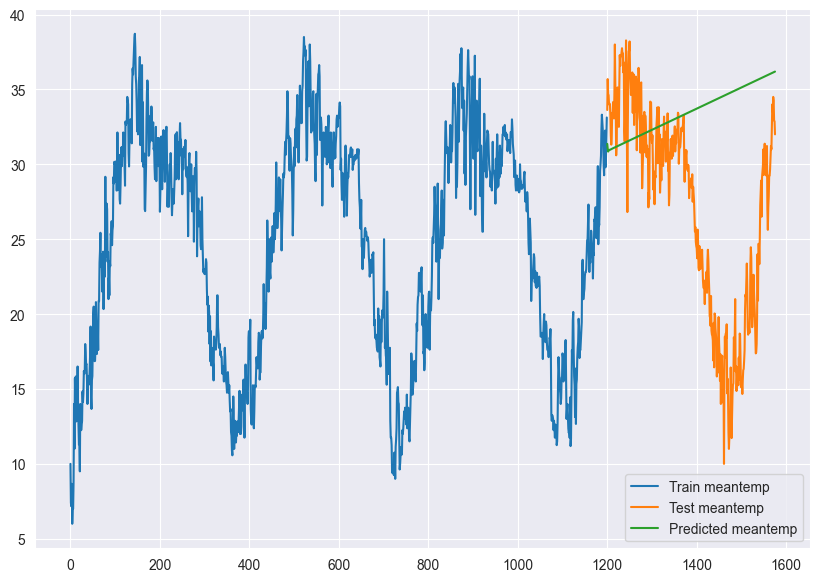

Evaluation metric for meantemp
MSE: 108.17764457978296
MAE: 7.966189903858331
RMSE: 10.400848262511234
SMAPE: 0.288
R2: -1.2287876175447403



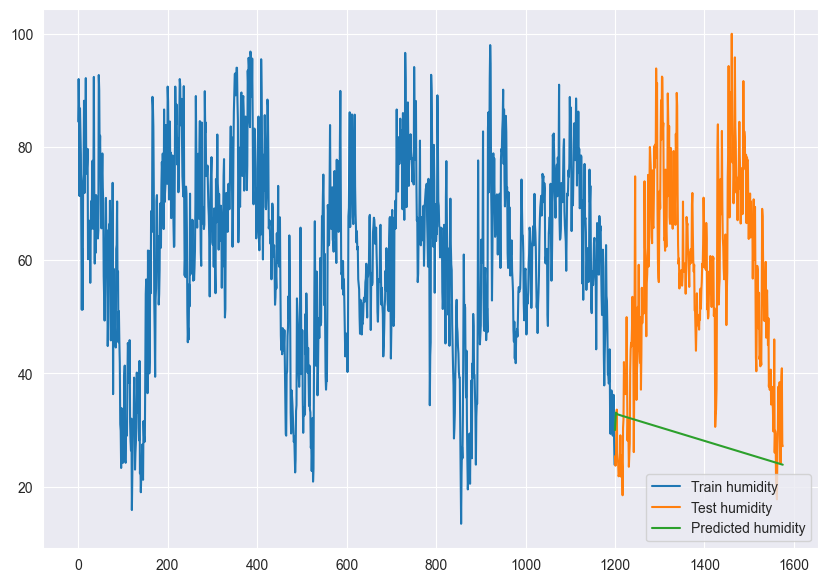

Evaluation metric for humidity
MSE: 1169.816924433398
MAE: 30.107945325667604
RMSE: 34.20258651671534
SMAPE: 0.653
R2: -2.780076356731094



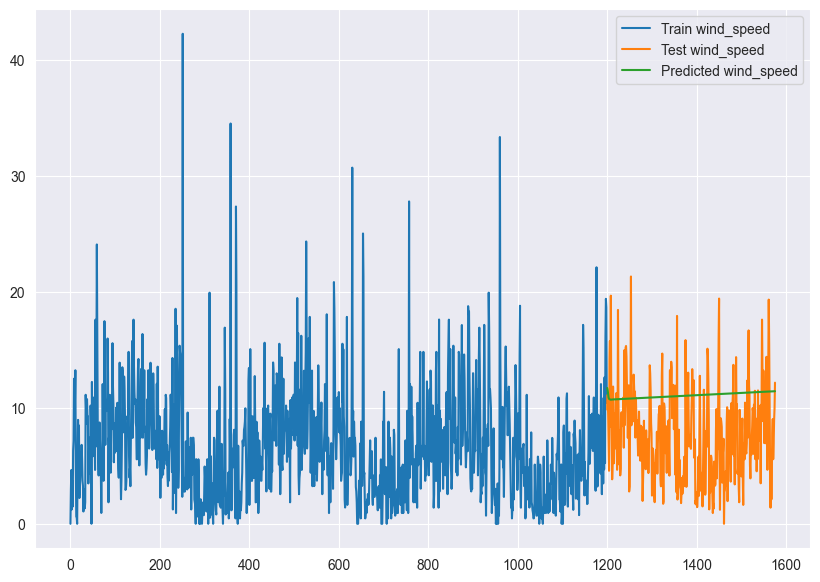

Evaluation metric for wind_speed
MSE: 26.07657142829482
MAE: 4.328753780027892
RMSE: 5.10652243981115
SMAPE: 0.529
R2: -0.804326364605412



In [161]:
for i in ['meantemp', 'humidity', 'wind_speed']:
    plt.rcParams["figure.figsize"] = [10,7]
    plt.plot(train[str(i)], label='Train '+str(i))
    plt.plot(range(1200, len(data)), test[str(i)], label='Test '+str(i))
    plt.plot(range(1200, len(data)), res[str(i)+'_1st_inv_diff'], label='Predicted '+str(i))
    plt.legend(loc='best')
    plt.show()

    print(f'Evaluation metric for {i}')
    timeseries_metrics(test[str(i)] , res[str(i)+'_1st_inv_diff'])

Очень плохие графики и очень плохие метрики, я очень расстроен

### Нейросети

LSTM
Long Short-Term Memory (LSTM) - это тип рекуррентной нейронной сети (RNN), разработанный для эффективной обработки и моделирования последовательных данных. LSTM создана с целью преодоления проблемы затухания градиента, которая возникает при обучении традиционных RNN на длинных последовательностях данных.

In [162]:
class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [163]:
def data_split(ts, param="2", train_percentage=0.9):
    timeseries = ts[ts.columns[int(param)]].values.astype('float32')
    train_size = int(len(timeseries) * train_percentage)
    train, test = timeseries[:train_size], timeseries[train_size:]
    return train, test, timeseries

In [164]:
def create_dataset(dataset, lookback):
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

In [165]:
def train_model(model, X_train, X_test, y_train, y_test, optimizer, loader, loss_l1, n_epochs):
    y_pred_train = None
    y_pred_test = None

    for epoch in range(n_epochs):
        model.train()
        for X_batch, y_batch in loader:
            y_pred = model(X_batch)
            loss = loss_l1(y_pred, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        model.eval()
        with torch.no_grad():
            y_pred = model(X_train)
            y_pred_train = y_pred
            train_rmse = np.sqrt(loss_l1(y_pred, y_train))
            y_pred = model(X_test)
            y_pred_test = y_pred
            test_rmse = np.sqrt(loss_l1(y_pred, y_test))
            print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))
            if (test_rmse < 2.3):
                break

    return y_pred_train, y_pred_test, model

In [166]:
data_LSTM = data.copy()

train, test, total = data_split(data_LSTM)
lookback = 1
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)

model = AirModel()
optimizer = optim.Adamax(model.parameters())
loss_fn = nn.MSELoss()
loader = torch_data.DataLoader(torch_data.TensorDataset(X_train, y_train), shuffle=True, batch_size=128)

EPOCHS = 100

y_pred_train, y_pred_test, model = train_model(model, X_train, X_test, y_train, y_test, optimizer, loader, loss_fn, EPOCHS)

Epoch 0: train RMSE 7.6720, test RMSE 7.9792
Epoch 1: train RMSE 6.9539, test RMSE 7.1998
Epoch 2: train RMSE 6.2122, test RMSE 6.3717
Epoch 3: train RMSE 5.5732, test RMSE 5.6029
Epoch 4: train RMSE 5.0720, test RMSE 4.9353
Epoch 5: train RMSE 4.7507, test RMSE 4.4298
Epoch 6: train RMSE 4.6073, test RMSE 4.1325
Epoch 7: train RMSE 4.5626, test RMSE 3.9928
Epoch 8: train RMSE 4.5502, test RMSE 3.9294
Epoch 9: train RMSE 4.5438, test RMSE 3.9115
Epoch 10: train RMSE 4.5381, test RMSE 3.8923
Epoch 11: train RMSE 4.5286, test RMSE 3.8965
Epoch 12: train RMSE 4.5175, test RMSE 3.8964
Epoch 13: train RMSE 4.5119, test RMSE 3.8783
Epoch 14: train RMSE 4.5026, test RMSE 3.8698
Epoch 15: train RMSE 4.4916, test RMSE 3.8577
Epoch 16: train RMSE 4.4783, test RMSE 3.8491
Epoch 17: train RMSE 4.4640, test RMSE 3.8377
Epoch 18: train RMSE 4.4472, test RMSE 3.8260
Epoch 19: train RMSE 4.4295, test RMSE 3.8126
Epoch 20: train RMSE 4.4120, test RMSE 3.8046
Epoch 21: train RMSE 4.3947, test RMSE 3.786

LSTM metrics: 
SMAPE: 0.382
RMSE: 3.3243475596555325
MAE: 2.6331367
MSE: 11.051287
R2: -1.9722017669279235


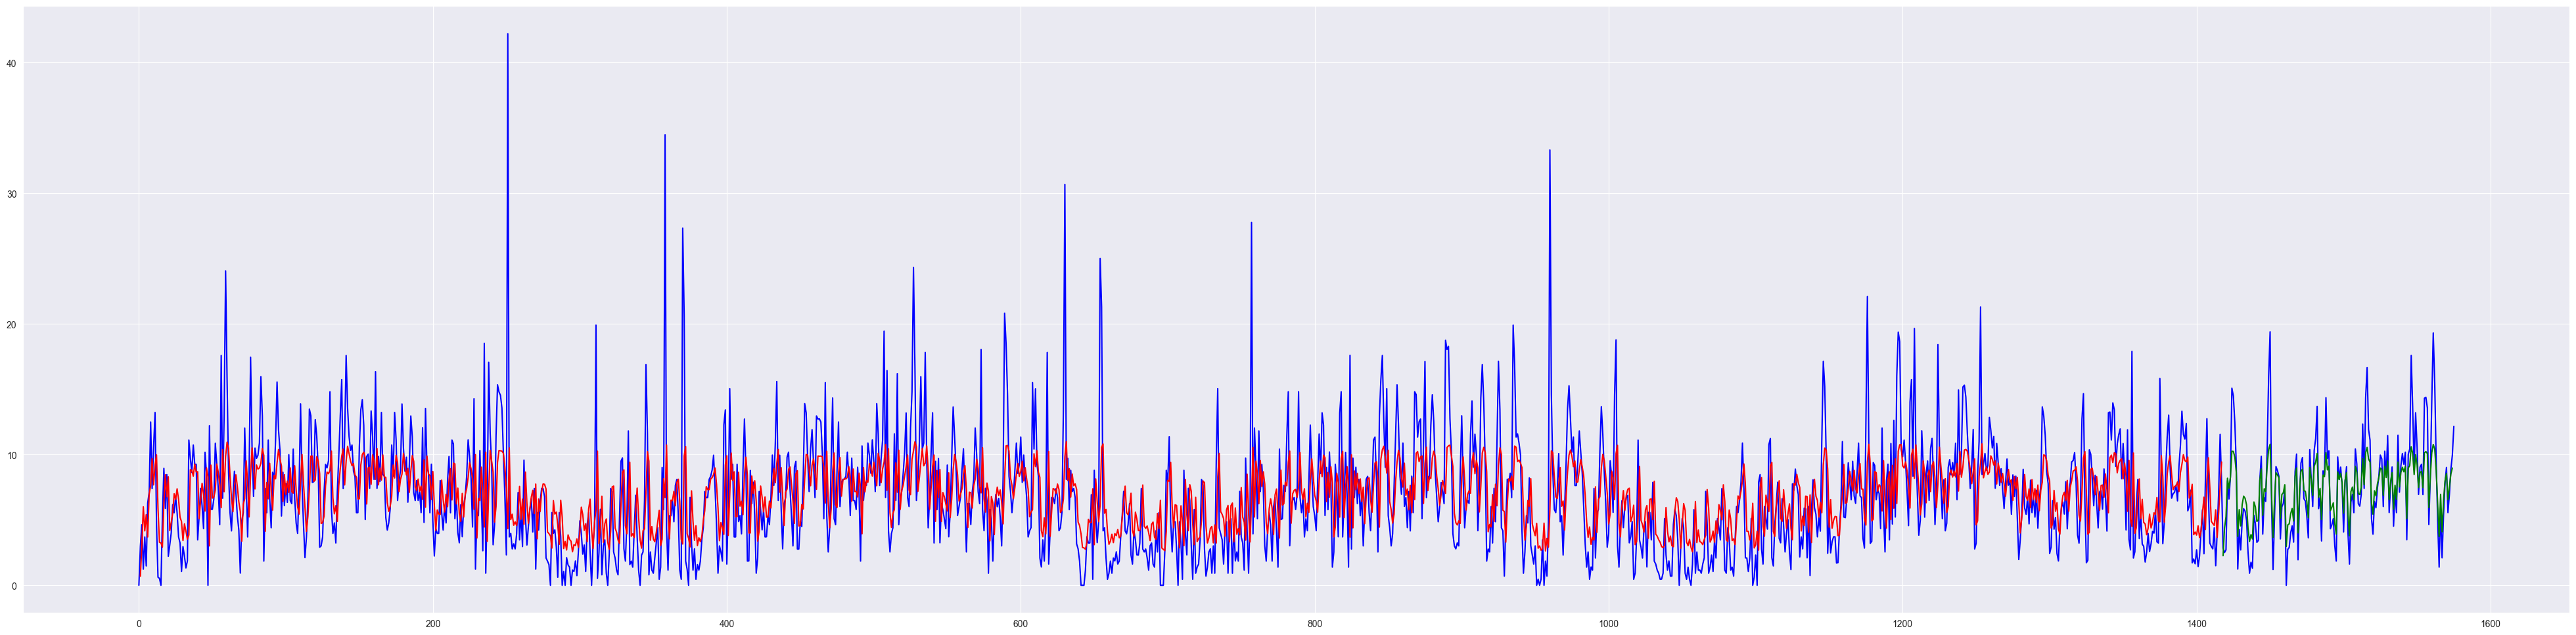

In [167]:

def validate(true, pred):
    true = pd.DataFrame(true.flatten().numpy())[0]
    pred = pd.DataFrame(pred.flatten().numpy())[0]

    print("SMAPE:", smape_score(true, pred))
    print("RMSE:", sqrt(mean_squared_error(true, pred)))
    print("MAE:", mean_absolute_error(true, pred))
    print("MSE:", mean_squared_error(true, pred))
    print("R2:", r2_score(true, pred))

def plot_train_n_pred(X_train, X_test, total, model):
    with torch.no_grad():
        train_plot = np.ones_like(total) * np.nan
        y_pred = model(X_train)
        y_pred = y_pred[:, -1]
        train_size = len(X_train)
        train_plot[lookback:train_size + 1] = model(X_train)[:, -1]
        test_plot = np.ones_like(total) * np.nan
        test_plot[train_size + lookback:len(total) - 1] = model(X_test)[:, -1]

    plt.rcParams["figure.figsize"] = [50, 12]
    plt.plot(total, c='b')
    plt.plot(train_plot, c='r')
    plt.plot(test_plot, c='g')
    plt.show()

def validate_on_auto_measurement(model):
    valid_train, valid_test, valid_total = data_split(data)
    lookback = 1
    X_train, _ = create_dataset(valid_train, lookback=lookback)
    X_test, y_test = create_dataset(valid_test, lookback=lookback)

    y_pred = model(X_test)
    y_pred_test = y_pred

    print("LSTM metrics: ")
    try:
        validate(y_pred_test, y_test)
    except:
        validate(y_pred_test.detach(), y_test.detach())
    plot_train_n_pred(X_train, X_test, valid_total, model)

validate_on_auto_measurement(model)

Обобщенно, модель LSTM демонстрирует хорошие показатели средней ошибки и процентного отклонения при прогнозировании временного ряда. Точность предсказаний является приемлемой, и модель может быть рассмотрена для использования в контексте данной задачи.

### GRU
Gated Recurrent Unit (GRU) - это тип рекуррентной нейронной сети (RNN), предназначенной для работы с последовательными данных, такими как временные ряды, тексты или звуковые сигналы. GRU является вариацией более традиционных RNN, предлагая решение для проблемы затухания градиента, с которой сталкиваются некоторые другие архитектуры.

In [168]:
class GRUModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.gru = nn.GRU(input_size=1, hidden_size=100, num_layers=1, batch_first=True)
        self.linear = nn.Linear(100, 1)
    def forward(self, x):
        x, _ = self.gru(x)
        x = self.linear(x)
        return x

In [169]:
def data_split(ts, param="2", train_percentage=0.9):
    timeseries = ts[ts.columns[int(param)]].values.astype('float32')
    train_size = int(len(timeseries) * train_percentage)
    train, test = timeseries[:train_size], timeseries[train_size:]
    return train, test, timeseries

In [170]:
def create_dataset(dataset, lookback):
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

In [171]:
def train_model(model, X_train, X_test, y_train, y_test, optimizer, loader, loss_l1, n_epochs, patience):
    y_pred_train = None
    y_pred_test = None
    min_test_rmse = np.inf
    epochs_no_improve = 0

    for epoch in range(n_epochs):
        model.train()
        for X_batch, y_batch in loader:
            y_pred = model(X_batch)
            loss = loss_l1(y_pred, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        model.eval()
        with torch.no_grad():
            y_pred = model(X_train)
            y_pred_train = y_pred
            train_rmse = np.sqrt(loss_l1(y_pred, y_train))
            y_pred = model(X_test)
            y_pred_test = y_pred
            test_rmse = np.sqrt(loss_l1(y_pred, y_test))

            if test_rmse < min_test_rmse:
                min_test_rmse = test_rmse
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1

            print(f'Epoch {epoch}: train RMSE {train_rmse:.4f}, test RMSE {test_rmse:.4f}')

            if epochs_no_improve == patience:
                print(f'Early stopping triggered after {epoch} epochs')
                break

    return y_pred_train, y_pred_test, model

In [172]:
data_GRU = data.copy()

train, test, total = data_split(data_GRU)
lookback = 1
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)

model = GRUModel()
optimizer = optim.Adamax(model.parameters())
loss_fn = nn.MSELoss()
loader = torch_data.DataLoader(torch_data.TensorDataset(X_train, y_train), shuffle=True, batch_size=128)

EPOCHS = 100

train_model(model, X_train, X_test, y_train, y_test, optimizer, loader, loss_fn, EPOCHS, patience=10)

Epoch 0: train RMSE 5.3253, test RMSE 5.2814
Epoch 1: train RMSE 4.5409, test RMSE 4.0553
Epoch 2: train RMSE 4.5248, test RMSE 3.8588
Epoch 3: train RMSE 4.4975, test RMSE 3.8228
Epoch 4: train RMSE 4.4589, test RMSE 3.8038
Epoch 5: train RMSE 4.4140, test RMSE 3.8042
Epoch 6: train RMSE 4.3678, test RMSE 3.7787
Epoch 7: train RMSE 4.3051, test RMSE 3.7232
Epoch 8: train RMSE 4.2441, test RMSE 3.6605
Epoch 9: train RMSE 4.2021, test RMSE 3.6303
Epoch 10: train RMSE 4.1664, test RMSE 3.5874
Epoch 11: train RMSE 4.1322, test RMSE 3.5354
Epoch 12: train RMSE 4.1076, test RMSE 3.4954
Epoch 13: train RMSE 4.0866, test RMSE 3.4557
Epoch 14: train RMSE 4.0734, test RMSE 3.4313
Epoch 15: train RMSE 4.0656, test RMSE 3.4242
Epoch 16: train RMSE 4.0521, test RMSE 3.3961
Epoch 17: train RMSE 4.0452, test RMSE 3.3836
Epoch 18: train RMSE 4.0374, test RMSE 3.3731
Epoch 19: train RMSE 4.0309, test RMSE 3.3564
Epoch 20: train RMSE 4.0300, test RMSE 3.3575
Epoch 21: train RMSE 4.0344, test RMSE 3.370

(tensor([[0.4154],
         [2.7789],
         [5.8872],
         ...,
         [5.4822],
         [7.5529],
         [9.4275]]),
 tensor([[ 2.1898],
         [ 4.1298],
         [ 4.9041],
         [ 8.1557],
         [ 7.3019],
         [ 8.0920],
         [10.2615],
         [10.0854],
         [ 9.5150],
         [ 8.2774],
         [ 3.7341],
         [ 5.6894],
         [ 4.6148],
         [ 6.1602],
         [ 6.7717],
         [ 6.6257],
         [ 6.1787],
         [ 4.5094],
         [ 3.1895],
         [ 3.5393],
         [ 3.1731],
         [ 6.2300],
         [ 6.0504],
         [ 5.0550],
         [ 5.1142],
         [ 8.0458],
         [ 8.7405],
         [ 5.4926],
         [ 7.3184],
         [ 7.0531],
         [ 9.0041],
         [10.4280],
         [10.7584],
         [ 6.7599],
         [ 3.6369],
         [ 6.3389],
         [ 8.5285],
         [ 8.1964],
         [ 7.9784],
         [ 5.2488],
         [ 6.8817],
         [ 6.9822],
         [ 7.5616],
         [

GRU metrics: 
SMAPE: 0.381
RMSE: 3.310601464105606
MAE: 2.6247659
MSE: 10.960082
R2: -2.102910766304916


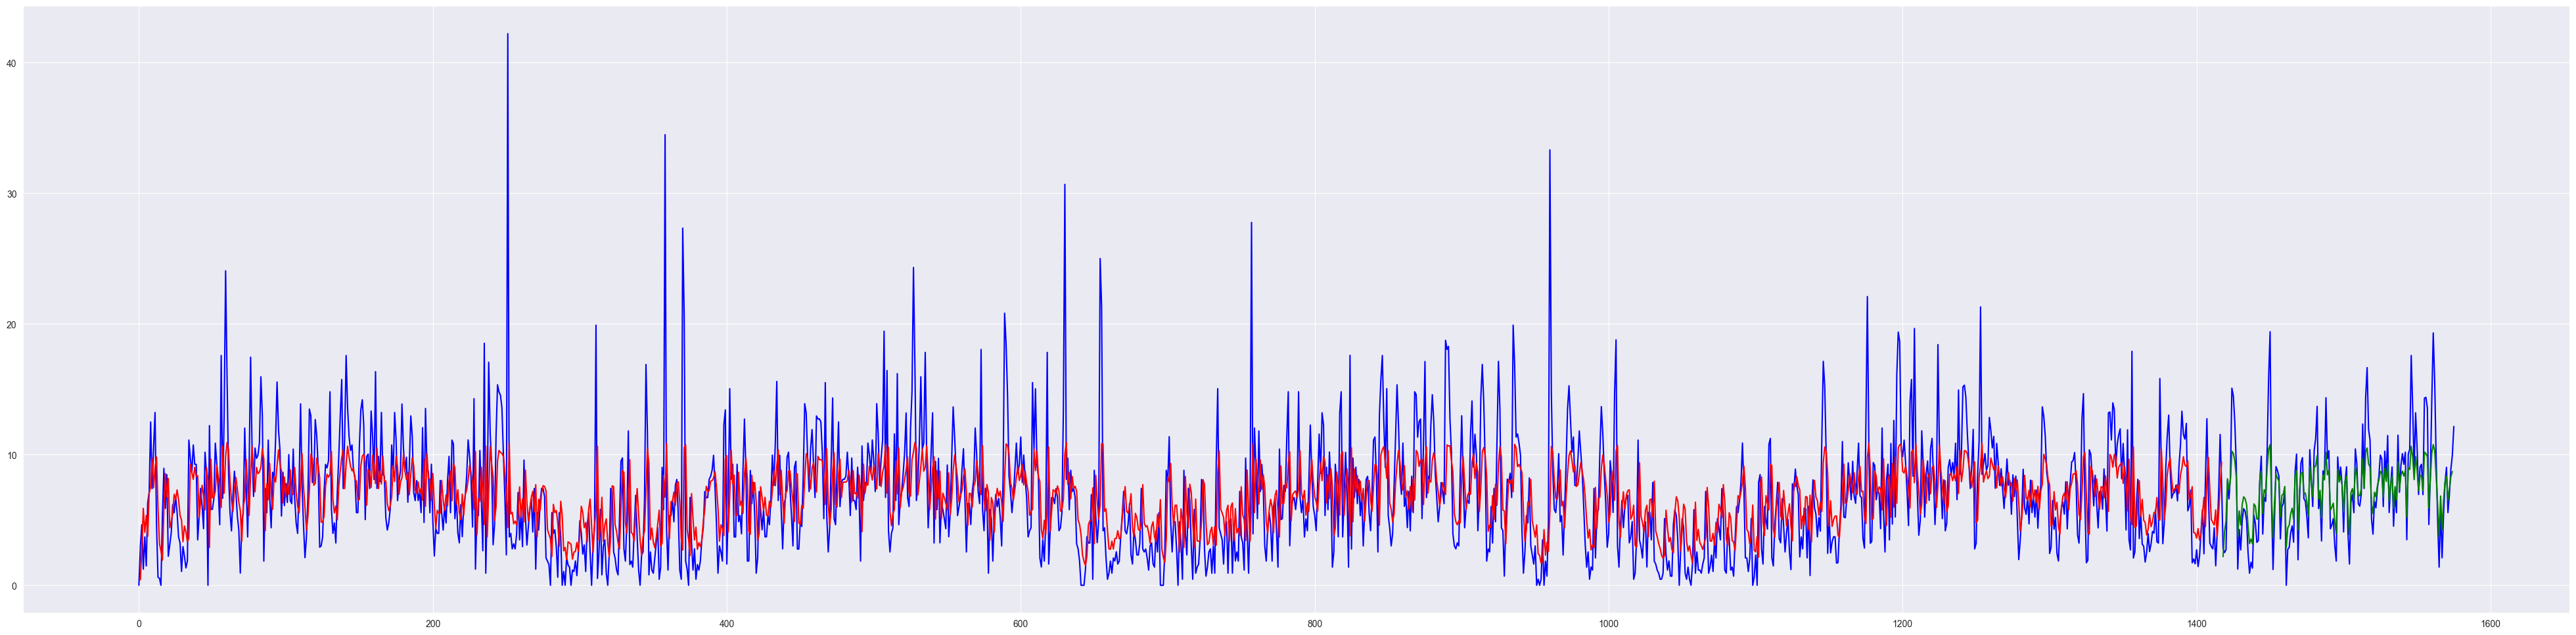

In [173]:
def validate(true, pred):
    true = pd.DataFrame(true.flatten().numpy())[0]
    pred = pd.DataFrame(pred.flatten().numpy())[0]

    print("SMAPE:", smape_score(true, pred))
    print("RMSE:", sqrt(mean_squared_error(true, pred)))
    print("MAE:", mean_absolute_error(true, pred))
    print("MSE:", mean_squared_error(true, pred))
    print("R2:", r2_score(true, pred))

def plot_train_n_pred(X_train, X_test, total, model):
    with torch.no_grad():
        train_plot = np.ones_like(total) * np.nan
        y_pred = model(X_train)
        y_pred = y_pred[:, -1]
        train_size = len(X_train)
        train_plot[lookback:train_size + 1] = model(X_train)[:, -1]
        test_plot = np.ones_like(total) * np.nan
        test_plot[train_size + lookback:len(total) - 1] = model(X_test)[:, -1]

    plt.rcParams["figure.figsize"] = [50, 12]
    plt.plot(total, c='b')
    plt.plot(train_plot, c='r')
    plt.plot(test_plot, c='g')
    plt.show()

def validate_on_auto_measurement(model):
    valid_train, valid_test, valid_total = data_split(data)
    lookback = 1
    X_train, _ = create_dataset(valid_train, lookback=lookback)
    X_test, y_test = create_dataset(valid_test, lookback=lookback)

    y_pred = model(X_test)
    y_pred_test = y_pred

    print("GRU metrics: ")
    try:
        validate(y_pred_test, y_test)
    except:
        validate(y_pred_test.detach(), y_test.detach())
    plot_train_n_pred(X_train, X_test, valid_total, model)

validate_on_auto_measurement(model)